# Sentiment Model Validation

In [1]:
import pandas as pd
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="sdcsentiment-584f24f06d91.json"
from google.cloud import language_v1
import seaborn as sns
import matplotlib.pyplot as plt
from preprocess_sentiment import preprocess_sentiment
from get_sentiment import get_sentiment_hf, get_sentiment_gcp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using Singapore server backend.


In [ ]:
# Ran once to retrieve random 50 rows for validation

'''
dfn = pd.read_excel("../preprocess_review/output/normalize_data/uss_reviews_normalized.xlsx")
dfn.drop(['date', 'rating', 'user','page_url','date_scraped','attraction', 'source'], axis=1, inplace=True)
df_valid = dfn.sample(50, replace=False) 
df_valid.to_excel("validate.xlsx", index=False)
'''

In [2]:
# Load in data after labelling sentiment
df_labelled = pd.read_excel("validate_labelled.xlsx")
df_labelled.head()

,review,self_sentiment
0,Tempat yang tak cukup dikelilingi 1 hari..Good...,positive
1,Biasa saja dan tidak ada yg baru,neutral
2,"Bagus banget , rugi kalau ga kesini kalau udah...",positive
3,Salah satu destinasi wisata populer di Singapu...,neutral
4,Tapi saya foto depan bola nya doang. Gak masuk...,negative


In [3]:
# Preprocess df
preprocess_sentiment(df_labelled)

In [4]:
# Rearrange dataframe
df_labelled = df_labelled[['review', 'new_reviews', 'self_sentiment']]
df_labelled.head()

,review,new_reviews,self_sentiment
0,Tempat yang tak cukup dikelilingi 1 hari..Good...,keliling 1 good place hati,positive
2,"Bagus banget , rugi kalau ga kesini kalau udah...",bagus banget rugi kesini singapore,positive
3,Salah satu destinasi wisata populer di Singapu...,ngomongngomong mahal ye temanteman 15an,neutral
4,Tapi saya foto depan bola nya doang. Gak masuk...,foto bola doang masuk uang sedi aink cemberut ...,negative
5,Waaah seru banget sih masuk USS gak nyesel. Ak...,waaah seru banget sih masuk uss nyesel kesini ...,positive


## Run Sentiment Models
Total runtime: 38m 50.8s

In [5]:
# HuggingFace Models
models = ["sahri/indonesiasentiment", 
          "w11wo/indonesian-roberta-base-sentiment-classifier", 
          "ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa", 
          "tyqiangz/indobert-lite-large-p2-smsa", 
          ]

df_labelled["sahri"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment_hf(x, models[0]))
df_labelled["w11wo"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment_hf(x, models[1]))
df_labelled["ayameRushia"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment_hf(x, models[2]))
df_labelled["tyqiangz"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment_hf(x, models[3]))
df_labelled["gcp"] = df_labelled['new_reviews'].apply(lambda x: get_sentiment_gcp(x))

In [6]:
df_labelled.head()

,review,new_reviews,self_sentiment,sahri,w11wo,ayameRushia,tyqiangz,gcp
0,Tempat yang tak cukup dikelilingi 1 hari..Good...,keliling 1 good place hati,positive,positive,positive,neutral,positive,positive
2,"Bagus banget , rugi kalau ga kesini kalau udah...",bagus banget rugi kesini singapore,positive,positive,positive,negative,negative,positive
3,Salah satu destinasi wisata populer di Singapu...,ngomongngomong mahal ye temanteman 15an,neutral,negative,negative,negative,negative,neutral
4,Tapi saya foto depan bola nya doang. Gak masuk...,foto bola doang masuk uang sedi aink cemberut ...,negative,negative,negative,negative,negative,negative
5,Waaah seru banget sih masuk USS gak nyesel. Ak...,waaah seru banget sih masuk uss nyesel kesini ...,positive,positive,positive,positive,positive,positive


In [7]:
true_lbl = df_labelled['self_sentiment']
sahri_lbl = df_labelled["sahri"]
w11wo_lbl = df_labelled["w11wo"] 
ayameRushia_lbl = df_labelled["ayameRushia"]
tyqiangz_lbl = df_labelled["tyqiangz"] 
gcp_lbl = df_labelled["gcp"]

In [8]:
sahri_cm = confusion_matrix(true_lbl, sahri_lbl)
w11wo_cm = confusion_matrix(true_lbl, w11wo_lbl)
ayameRushia_cm = confusion_matrix(true_lbl, ayameRushia_lbl)
tyqiangz_cm = confusion_matrix(true_lbl, tyqiangz_lbl)
gcp_cm = confusion_matrix(true_lbl, gcp_lbl)

In [9]:
sentiment_lbls = ['positive','neutral','negative']
sahri_df = pd.DataFrame(sahri_cm, index = sentiment_lbls, columns = sentiment_lbls)
w11wo_df = pd.DataFrame(w11wo_cm, index = sentiment_lbls, columns = sentiment_lbls)
ayameRushia_df = pd.DataFrame(ayameRushia_cm, index = sentiment_lbls, columns = sentiment_lbls)
tyqiangz_df = pd.DataFrame(tyqiangz_cm, index = sentiment_lbls, columns = sentiment_lbls)
gcp_df = pd.DataFrame(gcp_cm, index = sentiment_lbls, columns = sentiment_lbls)

In [10]:
def show_report(df, model_lbl):
  plt.figure(figsize=(5,4))
  sns.heatmap(df, annot=True)
  plt.title('Confusion Matrix')
  plt.ylabel('Actal Values')
  plt.xlabel('Predicted Values')
  plt.show()
  
  print('\nClassification Report\n')
  print(classification_report(true_lbl, model_lbl, target_names=['positive','neutral','negative']))

## sahri/indonesiasentiment

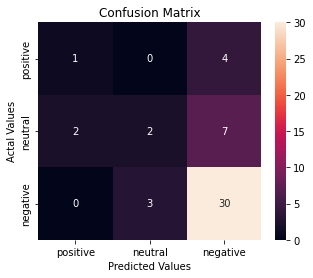


Classification Report

              precision    recall  f1-score   support

    positive       0.33      0.20      0.25         5
     neutral       0.40      0.18      0.25        11
    negative       0.73      0.91      0.81        33

    accuracy                           0.67        49
   macro avg       0.49      0.43      0.44        49
weighted avg       0.62      0.67      0.63        49



In [11]:
show_report(sahri_df, sahri_lbl)

## w11wo/indonesian-roberta-base-sentiment-classifier

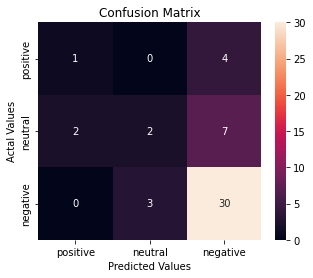


Classification Report

              precision    recall  f1-score   support

    positive       0.33      0.20      0.25         5
     neutral       0.40      0.18      0.25        11
    negative       0.73      0.91      0.81        33

    accuracy                           0.67        49
   macro avg       0.49      0.43      0.44        49
weighted avg       0.62      0.67      0.63        49



In [12]:
show_report(w11wo_df, w11wo_lbl)

## ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa

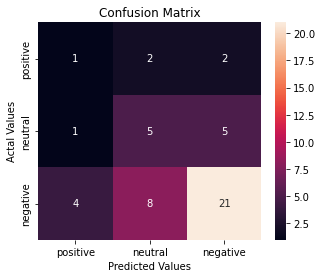


Classification Report

              precision    recall  f1-score   support

    positive       0.17      0.20      0.18         5
     neutral       0.33      0.45      0.38        11
    negative       0.75      0.64      0.69        33

    accuracy                           0.55        49
   macro avg       0.42      0.43      0.42        49
weighted avg       0.60      0.55      0.57        49



In [13]:
show_report(ayameRushia_df, ayameRushia_lbl)

## tyqiangz/indobert-lite-large-p2-smsa

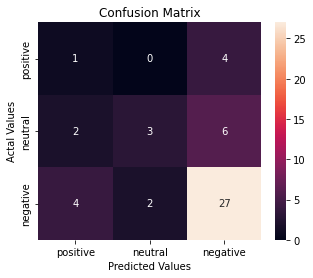


Classification Report

              precision    recall  f1-score   support

    positive       0.14      0.20      0.17         5
     neutral       0.60      0.27      0.37        11
    negative       0.73      0.82      0.77        33

    accuracy                           0.63        49
   macro avg       0.49      0.43      0.44        49
weighted avg       0.64      0.63      0.62        49



In [14]:
show_report(tyqiangz_df, tyqiangz_lbl)

## Google Cloud Platform

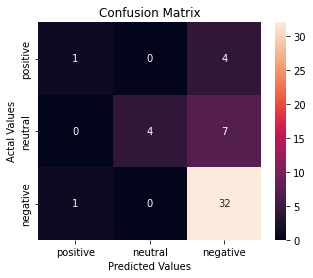


Classification Report

              precision    recall  f1-score   support

    positive       0.50      0.20      0.29         5
     neutral       1.00      0.36      0.53        11
    negative       0.74      0.97      0.84        33

    accuracy                           0.76        49
   macro avg       0.75      0.51      0.55        49
weighted avg       0.78      0.76      0.72        49



In [15]:
show_report(gcp_df, gcp_lbl)

High recall for negative is good for to not miss out any reviews that give valuable feedback.